#  Final project: the "1C" competition
This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

## File descriptions
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

## Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

# **Exploratory Data Analysis**

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
DATA_FOLDER = "./Data"
#train data
transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
#supplement data
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv')) #item id and its category id
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv')) #item category name
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv')) #shop name
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv')) #test data
sample_submission = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv')) #sample_submission

In [3]:
print("Shape of transactions: "+ str(transactions.shape))
transactions.head()

Shape of transactions: (2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## 1. Item Price:
Intuition: we can make some categories for prices

In [6]:
# item price
transactions.item_price.value_counts()
print("Number of prices:",transactions.item_price.nunique())
print("Maximum of prices:",transactions.item_price.max())
print("Data with maximum price:")
transactions[transactions.item_price==transactions.item_price.max()]

Number of prices: 19993
Maximum of prices: 307980.0
Data with maximum price:


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [7]:
max_id = transactions[transactions.item_price==transactions.item_price.max()].item_id.values[0]
items[items.item_id==max_id]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [8]:
transactions[transactions.item_id==max_id]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


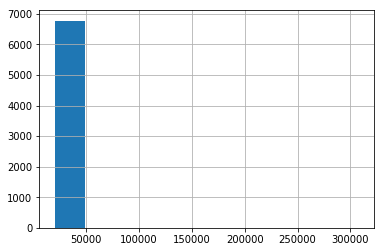

In [9]:
transactions[transactions.item_price>=20000].item_price.hist()

## 2. Item category & Shop Name

In [10]:
# Translate the item category name and find meta category, subtype
symbols=(u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ", u"abvgdeejzijklmnoprstufhzcss_y_euaABVGDEEJZIJKLMNOPRSTUFHZCSS_Y_EUA")
english = {ord(a):ord(b) for a, b in zip(*symbols)}

item_categories['items_english'] = item_categories['item_category_name'].apply(lambda x: x.translate(english))
item_categories['meta_category'] = item_categories['items_english'].apply(lambda x: x.split('-')[0])
item_categories['subtype'] = item_categories['items_english'].apply(lambda x: x.split('-')) \
                                                             .map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
item_categories.head(10)

,item_category_name,item_category_id,items_english,meta_category,subtype
0,PC - Гарнитуры/Наушники,0,PC - Garnitury/Nausniki,PC,Garnitury/Nausniki
1,Аксессуары - PS2,1,Aksessuary - PS2,Aksessuary,PS2
2,Аксессуары - PS3,2,Aksessuary - PS3,Aksessuary,PS3
3,Аксессуары - PS4,3,Aksessuary - PS4,Aksessuary,PS4
4,Аксессуары - PSP,4,Aksessuary - PSP,Aksessuary,PSP
5,Аксессуары - PSVita,5,Aksessuary - PSVita,Aksessuary,PSVita
6,Аксессуары - XBOX 360,6,Aksessuary - XBOX 360,Aksessuary,XBOX 360
7,Аксессуары - XBOX ONE,7,Aksessuary - XBOX ONE,Aksessuary,XBOX ONE
8,Билеты (Цифра),8,Bilety (Zifra),Bilety (Zifra),Bilety (Zifra)
9,Доставка товара,9,Dostavka tovara,Dostavka tovara,Dostavka tovara


In [11]:
print(item_categories.meta_category.value_counts())

Knigi                                13
Podarki                              12
Igry                                  8
Igrovye konsoli                       8
Aksessuary                            7
Programmy                             6
Muzyka                                6
Kino                                  5
Igry PC                               4
Karty oplaty                          4
Karty oplaty (Kino, Muzyka, Igry)     1
Dostavka tovara                       1
Cistye nositeli (stucnye)             1
Slujebnye                             1
Bilety (Zifra)                        1
Igry MAC                              1
Cistye nositeli (spil_)               1
Slujebnye                             1
Elementy pitania                      1
PC                                    1
Igry Android                          1
Name: meta_category, dtype: int64


In [12]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
item_categories["meta_category_code"] = labelencoder.fit_transform(item_categories["meta_category"])
item_categories["subtype_code"] = labelencoder.fit_transform(item_categories["subtype"])
item_categories = item_categories.drop(["items_english", "meta_category", "subtype"], axis=1)

In [13]:
item_categories.head(5)

,item_category_name,item_category_id,meta_category_code,subtype_code
0,PC - Гарнитуры/Наушники,0,16,23
1,Аксессуары - PS2,1,0,43
2,Аксессуары - PS3,2,0,44
3,Аксессуары - PS4,3,0,45
4,Аксессуары - PSP,4,0,47


In [14]:
# Translate the shop name and find towns
shops["shops_english"] = shops["shop_name"].apply(lambda x: x.translate(english))
shops["town"] = shops["shops_english"].apply(lambda x: x.split()[0])
shops.head(5)

,shop_name,shop_id,shops_english,town
0,"!Якутск Орджоникидзе, 56 фран",0,"!Akutsk Ordjonikidze, 56 fran",!Akutsk
1,"!Якутск ТЦ ""Центральный"" фран",1,"!Akutsk TZ ""Zentral_nyj"" fran",!Akutsk
2,"Адыгея ТЦ ""Мега""",2,"Adygea TZ ""Mega""",Adygea
3,"Балашиха ТРК ""Октябрь-Киномир""",3,"Balasiha TRK ""Oktabr_-Kinomir""",Balasiha
4,"Волжский ТЦ ""Волга Молл""",4,"Voljskij TZ ""Volga Moll""",Voljskij


In [15]:
# Label encoding
shops["town_code"] = labelencoder.fit_transform(shops["town"])
shops = shops.drop(["shops_english", "town"], axis=1)

In [16]:
shops.head(5)

,shop_name,shop_id,town_code
0,"!Якутск Орджоникидзе, 56 фран",0,0
1,"!Якутск ТЦ ""Центральный"" фран",1,0
2,"Адыгея ТЦ ""Мега""",2,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,4
4,"Волжский ТЦ ""Волга Молл""",4,27


## 3. Merge into transactions

In [17]:
# Make some useful features

# Remove dates
newcols = transactions["date"].str.split(".", expand=True)
ls = ["day", "month", "year"]
for i in range(len(ls)):
    transactions.insert(i, ls[i], newcols[i])
transactions['weekday'] = pd.to_datetime(transactions['date'], format = '%d.%m.%Y').dt.dayofweek
transactions.pop("date")

# Add item category for each item
transactions['item_category_id'] = [items['item_category_id'].values[i] for i in transactions['item_id'].values]

# Add revenues
transactions["revenue"] = transactions["item_price"]*transactions["item_cnt_day"]

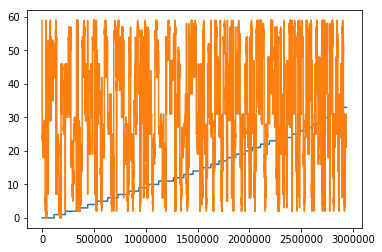

In [18]:
transactions.date_block_num.plot()
transactions.shop_id.plot()

In [19]:
transactions=transactions.merge(items, how='left')
transactions=transactions.merge(item_categories, how='left')
transactions=transactions.merge(shops, how='left')

In [20]:
transactions.drop("item_name",axis=1,inplace=True)
transactions.drop("shop_name",axis=1,inplace=True)
transactions.drop("item_category_name",axis=1,inplace=True)
transactions.head()

,day,month,year,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,item_category_id,revenue,meta_category_code,subtype_code,town_code
0,02,01,2013,0,59,22154,999.00,1.0,2,37,999.00,13,10,3
1,03,01,2013,0,25,2552,899.00,1.0,3,58,899.00,15,60,14
2,05,01,2013,0,25,2552,899.00,-1.0,5,58,-899.00,15,60,14
3,06,01,2013,0,25,2554,1709.05,1.0,6,58,1709.05,15,60,14
4,15,01,2013,0,25,2555,1099.00,1.0,1,56,1099.00,15,11,14


### 1) revenue analysis
* Peak at Christmas, low in summer
* peak at weekend
* some shop has really high revenues
* revenue goes up even with lower transactions

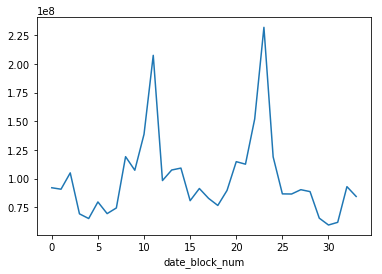

In [21]:
# revenue pick at Christmas and low in summer
transactions.groupby("date_block_num")["revenue"].sum().plot()

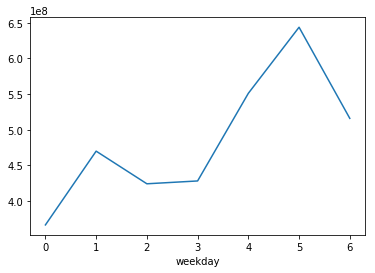

In [22]:
# revenue pick at weekends
transactions.groupby("weekday")["revenue"].sum().plot()

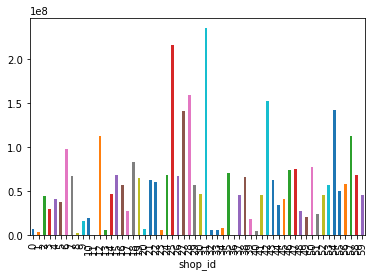

In [23]:
transactions.groupby("shop_id")["revenue"].sum().plot.bar()

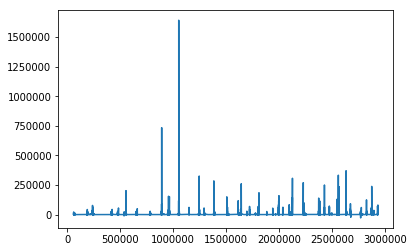

In [24]:
# One day has really high revenue
transactions[transactions["shop_id"]==31]["revenue"].plot()

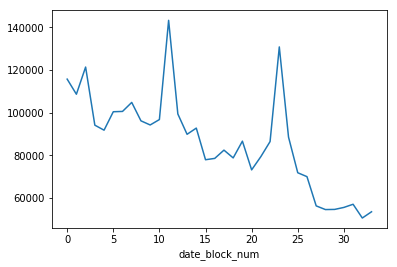

In [25]:
# the transactions are decreasing but the price is going up
# so the revenue is still increasing
transactions.groupby("date_block_num").count().revenue.plot()

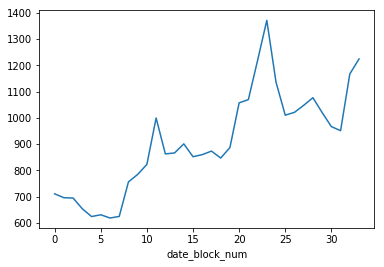

In [26]:
transactions.groupby("date_block_num").item_price.mean().plot()

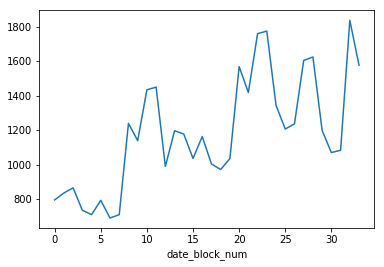

In [27]:
transactions.groupby("date_block_num").revenue.mean().plot()

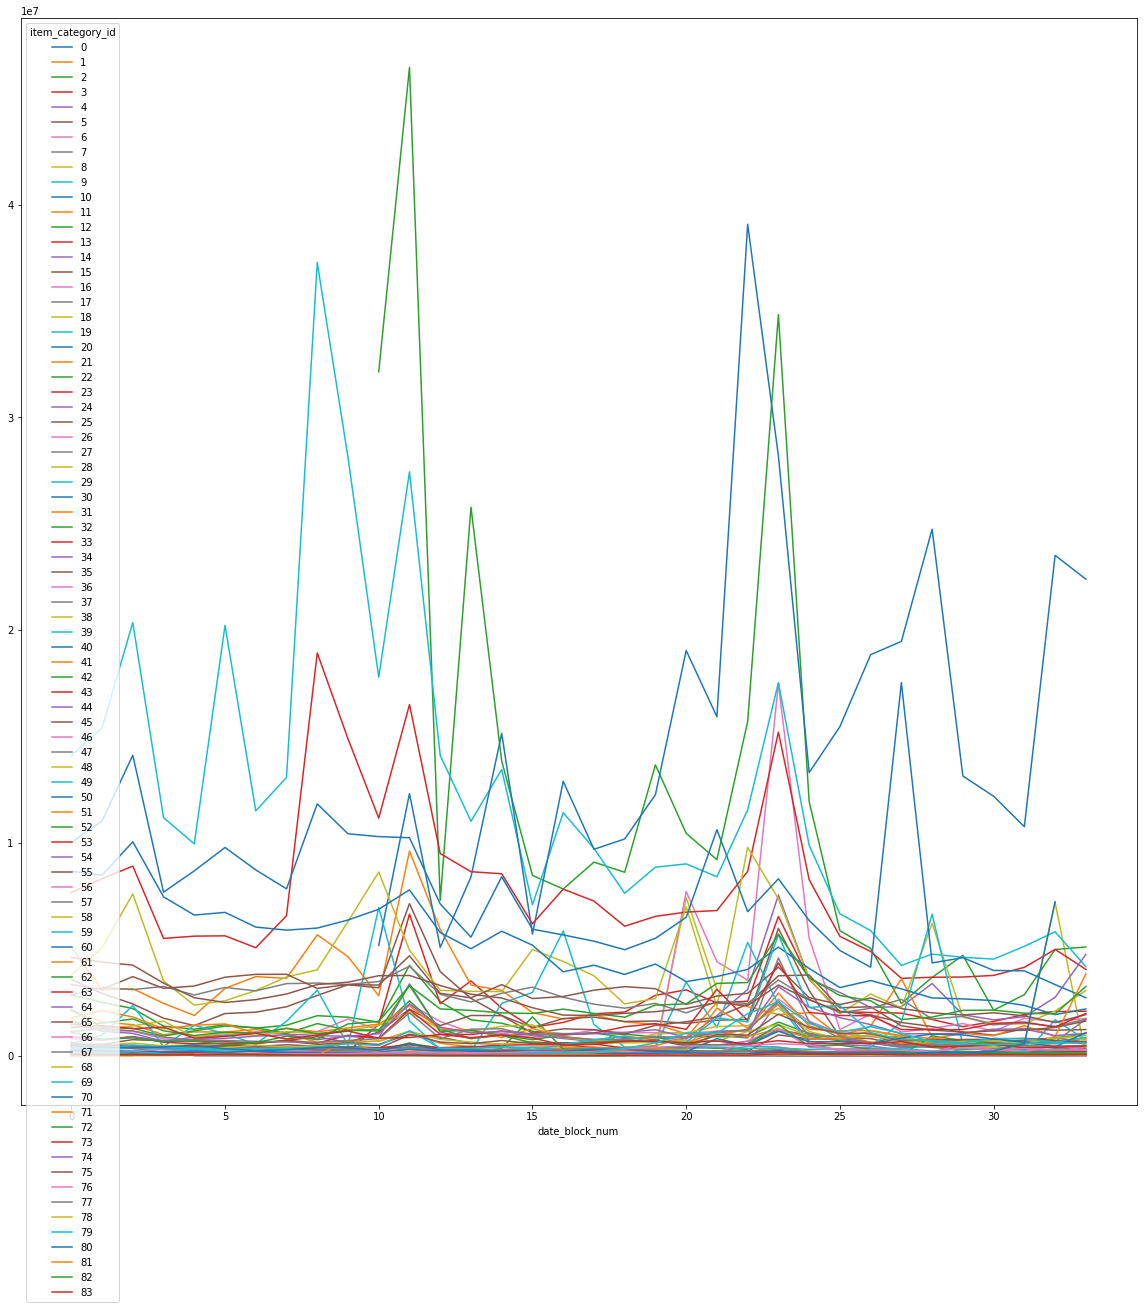

In [28]:
# item_category revenue
transactions.groupby(["date_block_num","item_category_id"]).sum()["revenue"].unstack().plot(figsize=(20,20))


### 2) shop analysis

* shop_id 10 and 11 are the same
* shop_id 9, 20 are not in test data

In [29]:
# Check the shop start day and last day
shop_life=pd.DataFrame(columns=["shop_id","Start", "Stop"])
shop_life["shop_id"]=np.arange(60)
shop_life["Start"]=transactions.groupby("shop_id")["date_block_num"].min()
shop_life["Stop"]=transactions.groupby("shop_id")["date_block_num"].max()
shop_life.merge(shops, how="left").drop("shop_name",axis=1)
shop_life.head(10)

,shop_id,Start,Stop
0,0,0,1
1,1,0,1
2,2,0,33
3,3,0,33
4,4,0,33
5,5,1,33
6,6,0,33
7,7,0,33
8,8,0,3
9,9,9,33


In [30]:
# a) shop 10 and 11 are the same
#    shop 1 and 58 are the same
#    shop 0 and 57 are the same
transactions.loc[transactions["shop_id"]==11,"shop_id"]=10
transactions.loc[transactions["shop_id"]==1,"shop_id"]=58
transactions.loc[transactions["shop_id"]==0,"shop_id"]=57

In [31]:
# b) check whether all the shops are both in train and test sets
test_list = list(sorted(test["shop_id"].unique()))
out_of_list = [i for i in list(range(60)) if i not in test_list]
print(out_of_list)

shop_not_active = shop_life[shop_life["Stop"]<33].shop_id
out_of_list_active = [i for i in out_of_list if i not in shop_not_active]
print(out_of_list_active)

# 9 and 20 only have limited transactions
transactions[(transactions["shop_id"]==9) | (transactions["shop_id"]==20)].groupby(["shop_id","date_block_num"]).sum()["revenue"]



[0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]
[9, 20]


shop_id  date_block_num
9        9                 5844108.0
         21                6615741.0
         27                  -3190.0
         33                3916178.0
20       21                3498559.0
         33                3101365.0
Name: revenue, dtype: float64

# Feature Engineering
## 1. Preprocessing
1. merge same shops & check shops in tests
2. remove outliers
3. Label Encoding:  
   Make categories for prices  
   Make item meta categories, subtypes  
   Make shop meta categories(towns) 

## 2. Make training data fit with testing data
1. make grids
2. merge item_cnt_month for each item
3. merge test and input zero
4. merge encoded label

## 3. Feature extraction
1. **Make lags features**


2. **Mean encoding with item_count_month**    
   1) monthly  
   2) monthly every item  
   3) monthly every shop  
   4) monthly every item category  
   5) monthly every shop every item category  
   6) monthly every shop every meta category  
   7) monthly every shop every subtype category  
   8) monthly every town  
   9) monthly every item every town  
   10) monthly every meta category  
   11) monthly every subtype category
   
   
3. **Mean encoding with item_price difference (trend)**    
   every item - monthly every item
   
   
4. **Mean encoding with revenue difference (trend)**    
   every shop - monthly every shop
   
5. **Time Interval for sales**  
   1) last sale and current sale  
   2) first sale and current sale  

(revenue trend: day_block_num, weekday, item_category, shop_id)



### Preprocessing

In [32]:
# 1.
# Remove outliers
transactions = transactions[transactions.item_price<100000]
transactions = transactions[transactions.item_cnt_day<1001]

In [33]:
# label encoding
# we have already done above

# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()

# transactions["meta_category_code"] = label_encoder.fit_transform(transactions["meta_category"])
# transactions["subtype_code"] = label_encoder.fit_transform(transactions["subtype"])
# transactions["town_code"] = label_encoder.fit_transform(transactions["town"])

In [34]:
transactions.head()

,day,month,year,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,item_category_id,revenue,meta_category_code,subtype_code,town_code
0,02,01,2013,0,59,22154,999.00,1.0,2,37,999.00,13,10,3
1,03,01,2013,0,25,2552,899.00,1.0,3,58,899.00,15,60,14
2,05,01,2013,0,25,2552,899.00,-1.0,5,58,-899.00,15,60,14
3,06,01,2013,0,25,2554,1709.05,1.0,6,58,1709.05,15,60,14
4,15,01,2013,0,25,2555,1099.00,1.0,1,56,1099.00,15,11,14


### Training & testing data

In [35]:
# 2.
# Make new training data to cartesian each shop/item pair
from itertools import product
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = transactions[transactions.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix.sort_values(cols, inplace=True)

In [36]:
# Merge item count month
group = transactions.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum'})
group.columns = ['item_cnt_month']
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

In [37]:
# Merge test into matrix
test["date_block_num"] = 34
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

In [38]:
# Merge encoded label into matrix
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_categories, on=['item_category_id'], how='left')

### Feature extraction

In [39]:
# 3.
# Make lags features
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

# Make lag encoded features for item_cnt_month
def encoded(matrix, cols, name, lags):
    a = matrix.copy()
    group = a.groupby(cols).agg({'item_cnt_month': ['mean']})
    group.columns = [name]
    group.reset_index(inplace=True)

    a = pd.merge(a, group, on=cols, how='left')
    a[name] = a[name].astype(np.float16)
    a = lag_feature(a, lags, name)
    a.drop([name], axis=1, inplace=True)
    return a

In [40]:
%%time
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

CPU times: user 40.6 s, sys: 16.3 s, total: 56.8 s
Wall time: 52.8 s


In [41]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_name,town_code,item_name,item_category_id,item_category_name,meta_category_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0.0,"Адыгея ТЦ ""Мега""",1,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD,13,15,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,"Адыгея ТЦ ""Мега""",1,"007 Legends [PS3, русская версия]",19,Игры - PS3,7,44,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,"Адыгея ТЦ ""Мега""",1,"007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания,10,56,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,"Адыгея ТЦ ""Мега""",1,"007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360,7,62,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,"Адыгея ТЦ ""Мега""",1,1+1,40,Кино - DVD,13,15,NaN,NaN,NaN,NaN,NaN
5,0,2,33,1.0,0.0,"Адыгея ТЦ ""Мега""",1,1+1 (BD),37,Кино - Blu-Ray,13,10,NaN,NaN,NaN,NaN,NaN
6,0,2,34,0.0,0.0,"Адыгея ТЦ ""Мега""",1,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,Кино - DVD,13,15,NaN,NaN,NaN,NaN,NaN
7,0,2,35,0.0,0.0,"Адыгея ТЦ ""Мега""",1,10 ЛЕТ СПУСТЯ,40,Кино - DVD,13,15,NaN,NaN,NaN,NaN,NaN
8,0,2,40,0.0,0.0,"Адыгея ТЦ ""Мега""",1,100 Best classical melodies (mp3-CD) (Digipack),57,Музыка - MP3,15,33,NaN,NaN,NaN,NaN,NaN
9,0,2,41,0.0,0.0,"Адыгея ТЦ ""Мега""",1,100 Best relax melodies (mp3-CD) (CD-Digipack),57,Музыка - MP3,15,33,NaN,NaN,NaN,NaN,NaN


In [42]:
%%time
# Make lag encoded features
"""
1) monthly
2) monthly every item
3) monthly every shop
4) monthly every item category
5) monthly every shop every item category
6) monthly every shop every meta category
7) monthly every shop every subtype category
8) monthly every town
9) monthly every item every town
10) monthly every meta category
11) monthly every subtype category
"""
matrix1 = encoded(matrix, ['date_block_num'], 'date_avg_item_cnt', [1])
matrix1 = encoded(matrix1, ['date_block_num', 'item_id'], 'date_item_avg_item_cnt', [1,2,3,6,12])
matrix1 = encoded(matrix1, ['date_block_num', 'shop_id'], 'date_shop_avg_item_cnt', [1,2,3,6,12])
matrix1 = encoded(matrix1, ['date_block_num', 'item_category_id'], 'date_category_avg_item_cnt', [1])
matrix1 = encoded(matrix1, ['date_block_num', 'shop_id', 'item_category_id'], 'date_shop_category_avg_item_cnt', [1])
matrix1 = encoded(matrix1, ['date_block_num', 'shop_id', 'meta_category_code'], 'date_shop_meta_category_avg_item_cnt', [1])
matrix1 = encoded(matrix1, ['date_block_num', 'shop_id', 'subtype_code'], 'date_shop_subtype_avg_item_cnt', [1])
matrix1 = encoded(matrix1, ['date_block_num', 'town_code'], 'date_town_avg_item_cnt', [1])
matrix1 = encoded(matrix1, ['date_block_num', 'item_id', 'town_code'], 'date_item_town_avg_item_cnt', [1])
matrix1 = encoded(matrix1, ['date_block_num', 'meta_category_code'], 'date_meta_category_avg_item_cnt', [1])
matrix1 = encoded(matrix1, ['date_block_num', 'subtype_code'], 'date_subtype_avg_item_cnt', [1])

CPU times: user 5min 35s, sys: 3min 12s, total: 8min 47s
Wall time: 7min 38s


In [43]:
matrix1 = matrix1.drop(["shop_name", "item_name", "item_category_name"], axis=1)
matrix1.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,ID,town_code,item_category_id,meta_category_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_category_avg_item_cnt_lag_1,date_shop_category_avg_item_cnt_lag_1,date_shop_meta_category_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_town_avg_item_cnt_lag_1,date_item_town_avg_item_cnt_lag_1,date_meta_category_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,1,40,13,15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,1,19,7,44,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,1,30,10,56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,1,23,7,62,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,1,40,13,15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,2,33,1.0,0.0,1,37,13,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,2,34,0.0,0.0,1,40,13,15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,2,35,0.0,0.0,1,40,13,15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,2,40,0.0,0.0,1,57,15,33,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,2,41,0.0,0.0,1,57,15,33,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
%%time
# Make lag encoded features for delta item price
group = transactions.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix1 = pd.merge(matrix1, group, on=['item_id'], how='left')
matrix1['item_avg_item_price'] = matrix1['item_avg_item_price'].astype(np.float16)

group = transactions.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix1 = pd.merge(matrix1, group, on=['date_block_num','item_id'], how='left')
matrix1['date_item_avg_item_price'] = matrix1['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix1 = lag_feature(matrix1, lags, 'date_item_avg_item_price')

for i in lags:
    matrix1['delta_price_lag_'+str(i)] = \
        (matrix1['date_item_avg_item_price_lag_'+str(i)] - matrix1['item_avg_item_price']) / matrix1['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix1['delta_price_lag'] = matrix1.apply(select_trend, axis=1)
matrix1['delta_price_lag'] = matrix1['delta_price_lag'].astype(np.float16)
matrix1['delta_price_lag'].fillna(0, inplace=True)

CPU times: user 5min 5s, sys: 59.2 s, total: 6min 4s
Wall time: 6min 1s


In [45]:
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix1.drop(fetures_to_drop, axis=1, inplace=True)

In [46]:
%%time
# Make lag encoded features for delta shop revenue
group = transactions.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix2 = pd.merge(matrix1, group, on=['date_block_num','shop_id'], how='left')
matrix2['date_shop_revenue'] = matrix2['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix2 = pd.merge(matrix2, group, on=['shop_id'], how='left')
matrix2['shop_avg_revenue'] = matrix2['shop_avg_revenue'].astype(np.float32)

matrix2['delta_revenue'] = (matrix2['date_shop_revenue'] - matrix2['shop_avg_revenue']) / matrix2['shop_avg_revenue']
matrix2['delta_revenue'] = matrix2['delta_revenue'].astype(np.float16)

matrix2 = lag_feature(matrix2, [1], 'delta_revenue')

matrix2.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

CPU times: user 23.9 s, sys: 20.6 s, total: 44.5 s
Wall time: 40.2 s


In [49]:
matrix2.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'town_code', 'item_category_id', 'meta_category_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_category_avg_item_cnt_lag_1',
       'date_shop_category_avg_item_cnt_lag_1',
       'date_shop_meta_category_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_town_avg_item_cnt_lag_1',
       'date_item_town_avg_item_cnt_lag_1',
       'date_meta_category_avg_item_cnt_lag_1',
       'date_subt

In [50]:
%%time
# months between the two sales of same products in all shops / same products in every shop
def interval_calc(im, name, shop):
    
    matrix = im.copy()
    cache = {}
    matrix[name] = -1
    
    for idx, row in matrix.iterrows():
        key = str(row.item_id)+' '+str(row.shop_id) if shop else row.item_id
        if key not in cache:
            if row.item_cnt_month != 0:
                cache[key] = row.date_block_num
        else:
            matrix.at[idx, name] = row.date_block_num - cache[key]
            cache[key] = row.date_block_num
    
    return matrix

matrix3 = interval_calc(matrix2, 'item_shop_interval', 1)
matrix3 = interval_calc(matrix3, 'item_interval', 0)

CPU times: user 29min 45s, sys: 22.1 s, total: 30min 7s
Wall time: 30min 37s


In [52]:
matrix3.tail(10)

,date_block_num,shop_id,item_id,item_cnt_month,ID,town_code,item_category_id,meta_category_code,subtype_code,item_cnt_month_lag_1,...,date_shop_meta_category_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_town_avg_item_cnt_lag_1,date_item_town_avg_item_cnt_lag_1,date_meta_category_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,item_shop_interval,item_interval
11127994,34,45,3280,0.0,214190.0,21,55,15,12,0.0,...,0.089294,0.126831,0.135376,0.0,0.146973,0.196899,0.171143,-0.290039,1,0
11127995,34,45,4393,0.0,214191.0,21,22,7,48,0.0,...,0.277344,0.135132,0.135376,0.0,0.494141,0.214355,-0.597168,-0.290039,1,0
11127996,34,45,4352,0.0,214192.0,21,22,7,48,0.0,...,0.277344,0.135132,0.135376,0.0,0.494141,0.214355,-0.181519,-0.290039,1,0
11127997,34,45,18049,0.0,214193.0,21,70,17,59,0.0,...,0.106201,0.139404,0.135376,0.0,0.237305,0.336426,-0.079773,-0.290039,1,0
11127998,34,45,18027,0.0,214194.0,21,70,17,59,0.0,...,0.106201,0.139404,0.135376,0.0,0.237305,0.336426,-0.105957,-0.290039,-1,0
11127999,34,45,18454,0.0,214195.0,21,55,15,12,1.0,...,0.089294,0.126831,0.135376,0.5,0.146973,0.196899,-0.475098,-0.290039,1,0
11128000,34,45,16188,0.0,214196.0,21,64,17,37,0.0,...,0.106201,0.094482,0.135376,0.0,0.237305,0.155884,0.081116,-0.290039,-1,0
11128001,34,45,15757,0.0,214197.0,21,55,15,12,0.0,...,0.089294,0.126831,0.135376,0.0,0.146973,0.196899,0.155884,-0.290039,1,0
11128002,34,45,19648,0.0,214198.0,21,40,13,15,0.0,...,0.097046,0.083740,0.135376,0.0,0.224243,0.220825,-0.091736,-0.290039,-1,0
11128003,34,45,969,0.0,214199.0,21,37,13,10,0.0,...,0.097046,0.126343,0.135376,0.5,0.224243,0.240967,-0.605957,-0.290039,1,0


In [53]:
# months between the first sale and current sale of same products in every shop / same products in same shop
matrix3['item_shop_interval_first'] = matrix3['date_block_num'] - \
                                      matrix3.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')
matrix3['item_interval_first'] = matrix3['date_block_num'] - \
                                      matrix3.groupby('item_id')['date_block_num'].transform('min')

### Final Preparation

In [54]:
# Lags are set 12, so remove data where date_block_num > 11
matrix3 = matrix3[matrix3['date_block_num']>11]

# Fill nan
for col in matrix3.columns:
    matrix3[col].fillna(0, inplace=True)         

matrix3.tail(10)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,date_block_num,shop_id,item_id,item_cnt_month,ID,town_code,item_category_id,meta_category_code,subtype_code,item_cnt_month_lag_1,...,date_town_avg_item_cnt_lag_1,date_item_town_avg_item_cnt_lag_1,date_meta_category_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,item_shop_interval,item_interval,item_shop_interval_first,item_interval_first
11127994,34,45,3280,0.0,214190.0,21,55,15,12,0.0,...,0.135376,0.0,0.146973,0.196899,0.171143,-0.290039,1,0,34,34
11127995,34,45,4393,0.0,214191.0,21,22,7,48,0.0,...,0.135376,0.0,0.494141,0.214355,-0.597168,-0.290039,1,0,19,19
11127996,34,45,4352,0.0,214192.0,21,22,7,48,0.0,...,0.135376,0.0,0.494141,0.214355,-0.181519,-0.290039,1,0,24,24
11127997,34,45,18049,0.0,214193.0,21,70,17,59,0.0,...,0.135376,0.0,0.237305,0.336426,-0.079773,-0.290039,1,0,8,8
11127998,34,45,18027,0.0,214194.0,21,70,17,59,0.0,...,0.135376,0.0,0.237305,0.336426,-0.105957,-0.290039,-1,0,5,5
11127999,34,45,18454,0.0,214195.0,21,55,15,12,1.0,...,0.135376,0.5,0.146973,0.196899,-0.475098,-0.290039,1,0,11,11
11128000,34,45,16188,0.0,214196.0,21,64,17,37,0.0,...,0.135376,0.0,0.237305,0.155884,0.081116,-0.290039,-1,0,2,2
11128001,34,45,15757,0.0,214197.0,21,55,15,12,0.0,...,0.135376,0.0,0.146973,0.196899,0.155884,-0.290039,1,0,34,34
11128002,34,45,19648,0.0,214198.0,21,40,13,15,0.0,...,0.135376,0.0,0.224243,0.220825,-0.091736,-0.290039,-1,0,11,11
11128003,34,45,969,0.0,214199.0,21,37,13,10,0.0,...,0.135376,0.5,0.224243,0.240967,-0.605957,-0.290039,1,0,17,17


In [73]:
# Add its month and days in that month
matrix3['month'] = matrix3['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix3['days'] = matrix3['month'].map(days).astype(np.int8)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [74]:
matrix3.to_pickle('data.pkl')

# Model

In [75]:
matrix3.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'town_code', 'item_category_id', 'meta_category_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_category_avg_item_cnt_lag_1',
       'date_shop_category_avg_item_cnt_lag_1',
       'date_shop_meta_category_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_town_avg_item_cnt_lag_1',
       'date_item_town_avg_item_cnt_lag_1',
       'date_meta_category_avg_item_cnt_lag_1',
       'date_subt

In [76]:
data = pd.read_pickle('data.pkl')

In [77]:
train = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'town_code',
    'item_category_id',
    'meta_category_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_category_avg_item_cnt_lag_1',
    'date_shop_category_avg_item_cnt_lag_1',
    #'date_shop_meta_category_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1', 
    'date_town_avg_item_cnt_lag_1',
    'date_item_town_avg_item_cnt_lag_1',
    #'date_meta_category_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1', 
    'delta_price_lag',
    #'delta_revenue_lag_1', 
    'item_shop_interval', 
    'item_interval',
    'item_shop_interval_first', 
    'item_interval_first',
    'month',
    'days'
]]

In [79]:
X_train = train[train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = train[train.date_block_num < 33]['item_cnt_month']
X_val = train[train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_val = train[train.date_block_num == 33]['item_cnt_month']
X_test = train[train.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [83]:
%%time
from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

[22:09:08] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15117	validation_1-rmse:1.11817
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10404	validation_1-rmse:1.08244
[2]	validation_0-rmse:1.06375	validation_1-rmse:1.05224
[3]	validation_0-rmse:1.02998	validation_1-rmse:1.02688
[4]	validation_0-rmse:1.00134	validation_1-rmse:1.00552
[5]	validation_0-rmse:0.976983	validation_1-rmse:0.988909
[6]	validation_0-rmse:0.955355	validation_1-rmse:0.973845
[7]	validation_0-rmse:0.937347	validation_1-rmse:0.961944
[8]	validation_0-rmse:0.921867	validation_1-rmse:0.952021
[9]	validation_0-rmse:0.909432	validation_1-rmse:0.944233
[10]	validation_0-rmse:0.897816	validation_1-rmse:0.936474
[11]	validation_0-rmse:0.888423	validati

In [103]:
import pickle
y_pred = model.predict(X_val).clip(0, 20)
y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(y_test, open('xgb_test.pickle', 'wb'))

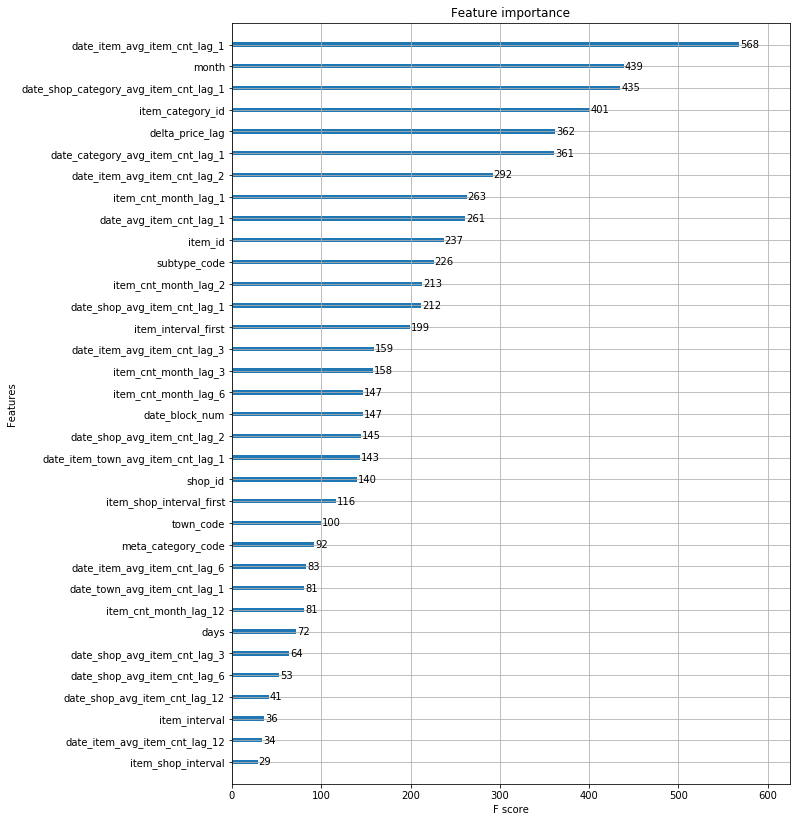

In [92]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1, figsize = (10,14))
plot_importance(booster = model, ax=ax)